# Confounding Example: Finding causal effects from observed data

Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)

## Let's create a mystery dataset for which we need to determine whether there is a causal effect.

Creating the dataset. It is generated from either one of two models:
* **Model 1**: Treatment does cause outcome. 
* **Model 2**: Treatment does not cause outcome. All observed correlation is due to a common cause.

In [2]:
rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, 
                                      num_common_causes=1, 
                                      sd_error=0.2)                                               
df = data_dict['df']                                                                                 
print(df[["Treatment", "Outcome", "w0"]].head())
                                                                                                                                                                                                         

   Treatment    Outcome        w0
0   3.807825   7.485299 -2.275653
1   2.099117   4.038841 -3.968616
2   2.729404   4.963784 -3.466725
3   7.902962  15.418299  1.995067
4   2.410521   4.911486 -3.666042


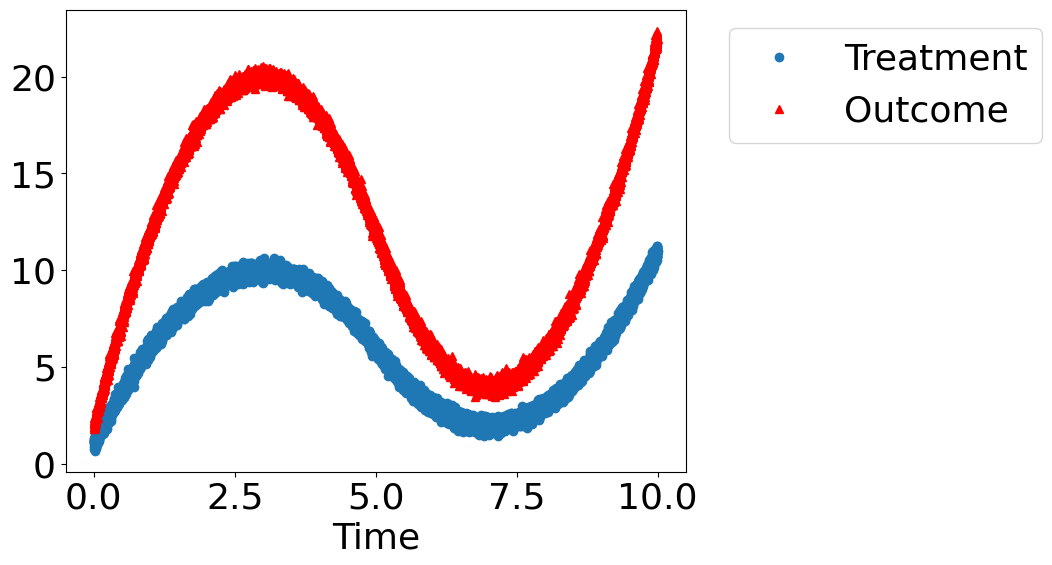

In [3]:
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])                                                       

## Using DoWhy to resolve the mystery: *Does Treatment cause Outcome?*
### STEP 1: Model the problem as a causal graph
Initializing the causal model.

In [4]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")                                                                                                                                                                                                                                             

Showing the causal model stored in the local file "causal_model.png"

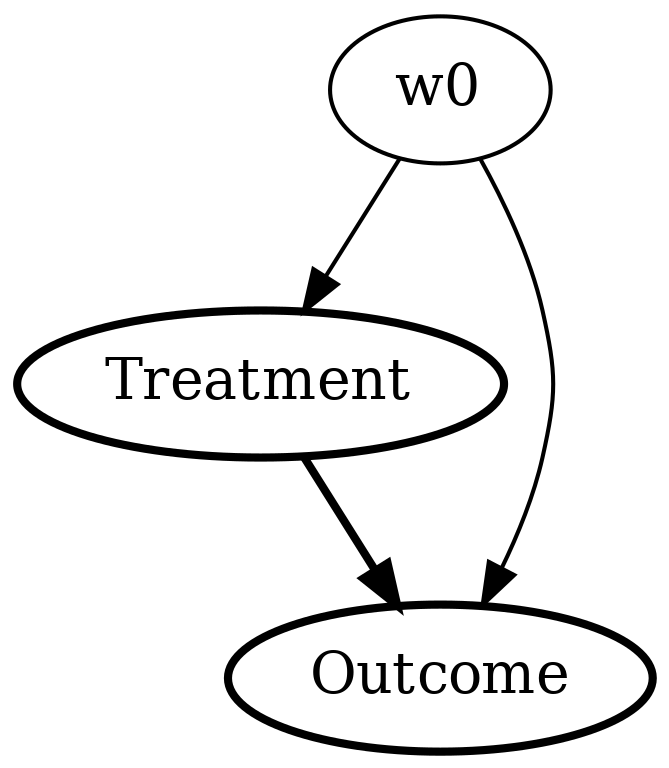

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph
Identify the causal effect using properties of the causal graph.

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### STEP 3: Estimate the causal effect

Once we have identified the estimand, we can use any statistical method to estimate the causal effect. 

Let's use Linear Regression for simplicity.

Causal Estimate is -0.007619803172369544


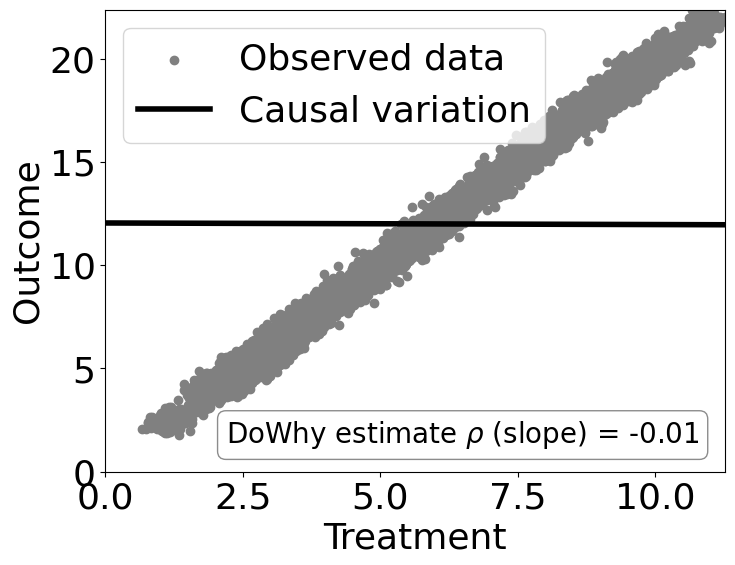

In [7]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between treamtent and outcome =causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

### Checking if the estimate is correct

In [8]:
print("DoWhy estimate is " + str(estimate.value)) 
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is -0.007619803172369544
Actual true causal effect was 0


### Step 4: Refuting the estimate

We can also refute the estimate to check its robustness to assumptions (*aka* sensitivity analysis, but on steroids). 

### Adding a random common cause variable

In [9]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.007619803172369544
New effect:-0.007627641299289323
p value:0.86



### Replacing treatment with a random (placebo) variable

In [10]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.007619803172369544
New effect:-0.00018089280182183033
p value:0.84



### Removing a random subset of the data

In [11]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)


Refute: Use a subset of data
Estimated effect:-0.007619803172369544
New effect:-0.008218092044778373
p value:0.74



As you can see, our causal estimator is robust to simple refutations.